## Asymmetry, wind shear, and motion

TODO: Raffiner les fits du Holland en prenant une moving window de thetas. Ensuite sauvegarder tous les plots. Mettre à jour le dossier de sauvegarde !!! 

NB: Proche du Rmax, il y a 2 bosses et 2 creux dans V(theta), i.e une asymétrie d'ordre WN2, ce qui fait que mon fit est mauvais et converge vers 0.1 m/s, i.e la borne inférieure. Je peux éliminer ces régions en comparant à la RMSE. Avec les figures, on voit que le WN2 domine dans l'inner-core. A partir de 1.5*Rmax, le WN1 domine. Donc on va pouvoir utiliser le WN1 pour calibrer Kepert pour r > Rmax.

CHECK: Traiter l'hémisphère Sud séparément (pas sûr de mon storm_dir_adjusted) ?

NB: Je ne peux pas checker la dépendance de (c1, c2) au motion/wind shear pour le modèle K25_wIA car je n'ai pas assez de cas.

Rappel: Downshear = in the direction of the vertical wind shear vector.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/Tests/test_asymmetry_windshear/',
}

PRMS = {
    'sav_fgs': False
}

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [4]:
#########################
### General functions ###
#########################
def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def wn2(thetas, a, phi, c):
    return a * np.cos(2 * thetas + phi) + c

def get_wn2(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn2,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def wn1and2(thetas, a1, phi1, a2, phi2, c):
    return a1 * np.cos(1 * thetas + phi1) + a2 * np.cos(2 * thetas + phi2) + c

def get_wn1and2(thetas, wind_speed, initial_condition=15, upper_bound=80):
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1and2,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1, 0., 0.1], [upper_bound, np.pi, upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a1, phi1, a2, phi2, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    return a1, phi1, a2, phi2, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset
rs = np.linspace(100, 5e5, 5000)    # Symetric
xs = np.linspace(1000, 250000, 250) # Asymetric

### Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}
# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [6]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 33) & 
    (dsg.dist2coast > dsg.r34)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

343


In [7]:
L_ACN1     = [] # WN1
L_ACN2     = [] # WN2
L_ACN1_    = [] # WN1 of combined WN1&2
# L_AQD      = []
L_ACN_HOL1 = [] # WN1
L_ACN_HOL2 = [] # WN2
L_ERR1     = []
L_ERR2     = []
L_VTS      = []
L_FIL      = []
TIMES      = []

for t in tqdm(range(len(d.time))):
    ### Open
    ds  = d.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

    ###########################
    ### Compute asymmetries ###
    ###########################

    ### 1) Compute Asymmetries using cosine amplitudes
    ACN1    = [] # Amplitude of cosine - WN1
    ACN2    = [] # Amplitude of cosine - WN2
    ACN1_   = [] # Amplitude of cosine - WN1 of combined WN1&2
    # ACN_AVG = [] # Amplitude of cosine averaged on th and r
    ERR1    = [] # Error of fit - WN1
    ERR2    = [] # Error of fit - WN2
    VTS     = [] # Nb of valid thetas
    
    # AQD     = [] # Amplitude of quantile difference
    # q       = 0.25
    
    for rad in xs:
        valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
        if len(valid_dsp.theta) > 10:
            # Amplitude of cosine - WN1
            acn1, phi1, c1                 = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
            error1                         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), acn1, phi1, c1), valid_dsp.wind_speed)) 
            # # Amplitude of quantile difference
            # aqd            = valid_dsp.wind_speed.quantile(1 - q) - valid_dsp.wind_speed.quantile(q)
            # Amplitude of cosine - WN2
            acn2, phi2, c2                 = get_wn2(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
            error2                         = float(rmse(wn2(np.deg2rad(valid_dsp.theta), acn2, phi2, c2), valid_dsp.wind_speed)) 
            # Amplitude of cosine - combined WN1&2
            acn1_, phi1_, acn2_, phi2_, c_ = get_wn1and2(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
        else:
            acn1   = phi1  = c1    = error1     = np.nan
            acn2   = phi2  = c2    = error2     = np.nan
            acn1_  = phi1_ = acn2_ = phi2_ = c_ = np.nan
        # Append
        ACN1.append(acn1)
        ERR1.append(error1)
        ERR2.append(error2)
        VTS.append(len(valid_dsp.theta))
        # AQD.append(aqd)
        ACN2.append(acn2)
        ACN1_.append(acn1_)

        # # Prepare averagings
        # Vh          = holland_profile(rs, abs(float(ds.lat)), float(ds.B_hol), float(ds.vmx_hol), float(ds.rmx_hol), float(ds.vmn_hol))
        # timescale   = 1 / I(rs, Vh, float(abs(ds.fcor)))[0, :] # time needed for the BL to develop
        # radialscale = timescale * Vh / 5                       # radial distance travelled by an air parcel in the meantime, considering that U/V = 5
        # tangenscale = timescale * Vh                           # tangential distance travelled by an air parcel in the meantime
        # thetascale  = 360 * tangenscale / (2 * np.pi * rs)     # convert this tangential distance to theta
        # thetascale[np.isnan(thetascale)] = 9999                # happens when time 1/I explodes, so put a high value to enter the ValueError exception below (AS2 and AS3 computation)
        # # Amplitude of cosine  averaged on theta AND r
        # valid_dsp_avg           = dsp.sel(rad=slice(rad - avg_on_u, rad + avg_on_u))[['wind_speed']].mean(dim='rad', skipna=True).rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(dim='theta')
        # acn_avg, phi_avg, c_avg = get_wn1(np.deg2rad(valid_dsp3.theta), valid_dsp3.wind_speed, float(ds.vps), float(ds.vmx))
        # ACN_AVG.append(acn_avg)

    ### 2)Compute asymmetries using Holland
    LWS      = [] # To save the Holland wind speeds
    ACN_HOL1 = [] # Amplitude of cosine using Holland - WN1
    ACN_HOL2 = [] # Amplitude of cosine using Holland - WN2

    for th in th_steps:
        ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
        wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
        r_crop, spdm_crop = initialize_radius(np.array(wsm))
        try:
            # Holland
            popt, pcov = curve_fit(
                lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, float(abs(ds.lat)), B, Vmin, Rmax, Vmax), 
                np.array(r_crop), 
                np.array(spdm_crop), 
                p0=[1.8, 5, 20 * 1000, 40], 
                bounds=(
                    tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                    tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
                ) 
            ) 
            B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        except RuntimeError:
            B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        # Append
        LWS.append(holland_profile(rs, float(abs(ds.lat)), B_hol, vmn_hol, rmx_hol, vmx_hol))
    # Create dataset structure
    dsh = xr.Dataset(
        data_vars={
            'ws':        (('th', 'rad'), LWS),
        },
        coords={
            'th': th_steps,
            'rad': rs,
        }
    )
    # Compute Asymmetries
    for rad in xs:
        # WN1
        acn_hol1, phi_hol1, c_hol1 = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').th), dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').ws, 5., float(ds.vmx))
        ACN_HOL1.append(acn_hol1)
        # WN2
        acn_hol2, phi_hol2, c_hol2 = get_wn2(np.deg2rad(dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').th), dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').ws, 5., float(ds.vmx))
        ACN_HOL2.append(acn_hol2)
    
    ### Append
    L_ACN1.append(ACN1)
    # L_AQD.append(AQD)
    L_FIL.append(ds.file_tcva.item())
    TIMES.append(ds.time.data)
    L_ACN2.append(ACN2)
    L_ACN1_.append(ACN1_)
    L_ERR1.append(ERR1)
    L_ERR2.append(ERR2)
    L_VTS.append(VTS)
    
    L_ACN_HOL1.append(ACN_HOL1)
    L_ACN_HOL2.append(ACN_HOL2)

    ############
    ### Plot ###
    ############
    
    fig          = plt.figure(figsize=(20, 20))
    gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
    cmap         = plt.get_cmap('PuOr') # Spectral
    normalizer   = Normalize(0, 80)
    ax_lims2D    = 400
    ts           = pd.to_datetime(str(ds.time.values)) 
    dt           = ts.strftime('%Y-%m-%d, %H:%M')
    plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s, Wind shear = {:.1f} m/s \nStorm dir = {:.0f}°EoN, Shear dir = {:.0f}°EoN'.format(ds.name.item(), ds.id.item(), dt, ds.speed, ds.vws_pmd, ds.storm_dir_ibt, ds.wsd_pmd), y=0.94)
    
    ### Plot SAR
    ax           = fig.add_subplot(gs[0, 0])
    dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
    ds_x, ds_y   = pol2cart(dr, th)
    ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
    im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)
    
    # Axes
    ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
    ax.set_ylabel(r'Distance from TC center (km)')
    ax.set_xlabel(r'Distance from TC center (km)')
    ax.set_box_aspect(1)
    ax.minorticks_on()
    ax.tick_params(length=7, width=1.2)
    ax.grid()
    
    ax2 = ax.twinx().twiny() 
    ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
    ax2.minorticks_on()
    ax2.tick_params(axis='both', length=7, width=1.2)
    ax2.set_box_aspect(1)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    
    # Colorbar
    cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
    cbar  = fig.colorbar(im, cax=cb_ax)
    cbar.set_label(r'Wind speed (m/s)', rotation=90)
    cbar.ax.get_yaxis().labelpad=5
    
    ### Plot asymmetries (SAR + Kepert)
    ax       = fig.add_subplot(gs[1, 0])

    ax.plot(xs / 1000, ACN_HOL1, c='k',          linewidth=3,        label='Amplitude of cosine using Holland - WN1')
    ax.plot(xs / 1000, ACN_HOL2, c='tab:blue',   linewidth=3,        label='Amplitude of cosine using Holland - WN2')
    ax.plot(xs / 1000, ACN1,     c='k',                              label='Amplitude of cosine - WN1')
    ax.plot(xs / 1000, ACN2,     c='tab:blue',                       label='Amplitude of cosine - WN2')
    ax.plot(xs / 1000, ACN1_,    c='tab:purple',                     label='WN1 of combined WN1&2')
    # ax.plot(xs / 1000, AS3, c='k',          linestyle='dashed', label='Amplitude of cosine, avg. on th AND r')
    ax.plot(xs / 1000, ERR1,     c='k',        linestyle='dashed', label='RMSE in fitting cosine (non-avg.) - WN1')
    ax.plot(xs / 1000, ERR2,     c='tab:blue', linestyle='dashed', label='RMSE in fitting cosine (non-avg.) - WN2')
    ACN_SUM = np.array(ACN_HOL1 ) + np.array(ACN_HOL2)
    ax.plot(xs / 1000, ACN_SUM,  c='tab:gray', linewidth=3,        label='Sum WN1 + WN2 using Holland')
    # Wind radii
    ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
    ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
    ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')
    
    # Validity curves
    ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Ratio of valid thetas - must be close to 1')
    ax.axhline(1, c='gray', alpha=0.3)
    
    # Legends
    ax.set_xlabel(r'Distance from TC center (km)')
    ax.set_ylabel('Asymmetry amplitude (m/s)')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
    ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
    ax.set_ylim(0, 0.2 + float(max(max(ACN1), max(ERR1), max(ACN_SUM), ds.speed + 1)))
    ax.grid()

    ### Save
    if PRMS['sav_fgs']:
        plt.savefig(PTHS['sav_dir'] + 'cases/' + ds.file_tcva.item()[:-3], bbox_inches='tight', format='png');plt.clf()
    else:
        plt.show()

  0%|          | 0/343 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
# Concatenate into a single dataset
dsa = xr.Dataset(
    data_vars={
        'acn1':       (('time', 'rad'), L_ACN1),
        'acn2':       (('time', 'rad'), L_ACN2),
        'acn_hol1':   (('time', 'rad'), L_ACN_HOL1),
        'acn_hol2':   (('time', 'rad'), L_ACN_HOL2),
        'err1':       (('time', 'rad'), L_ERR1),
        'err2':       (('time', 'rad'), L_ERR2),
        'vts':        (('time', 'rad'), L_VTS),
        'file_tcva':  ('time', L_FIL),
    },
    coords={
        'time': TIMES
    }
)

In [ ]:
# # Eventually save
# dsa.to_netcdf(PTHS['sav_dir'] + 'dsa.nc')

In [8]:
# Eventually load
dsa = xr.open_dataset(PTHS['sav_dir'] + 'dsa.nc')

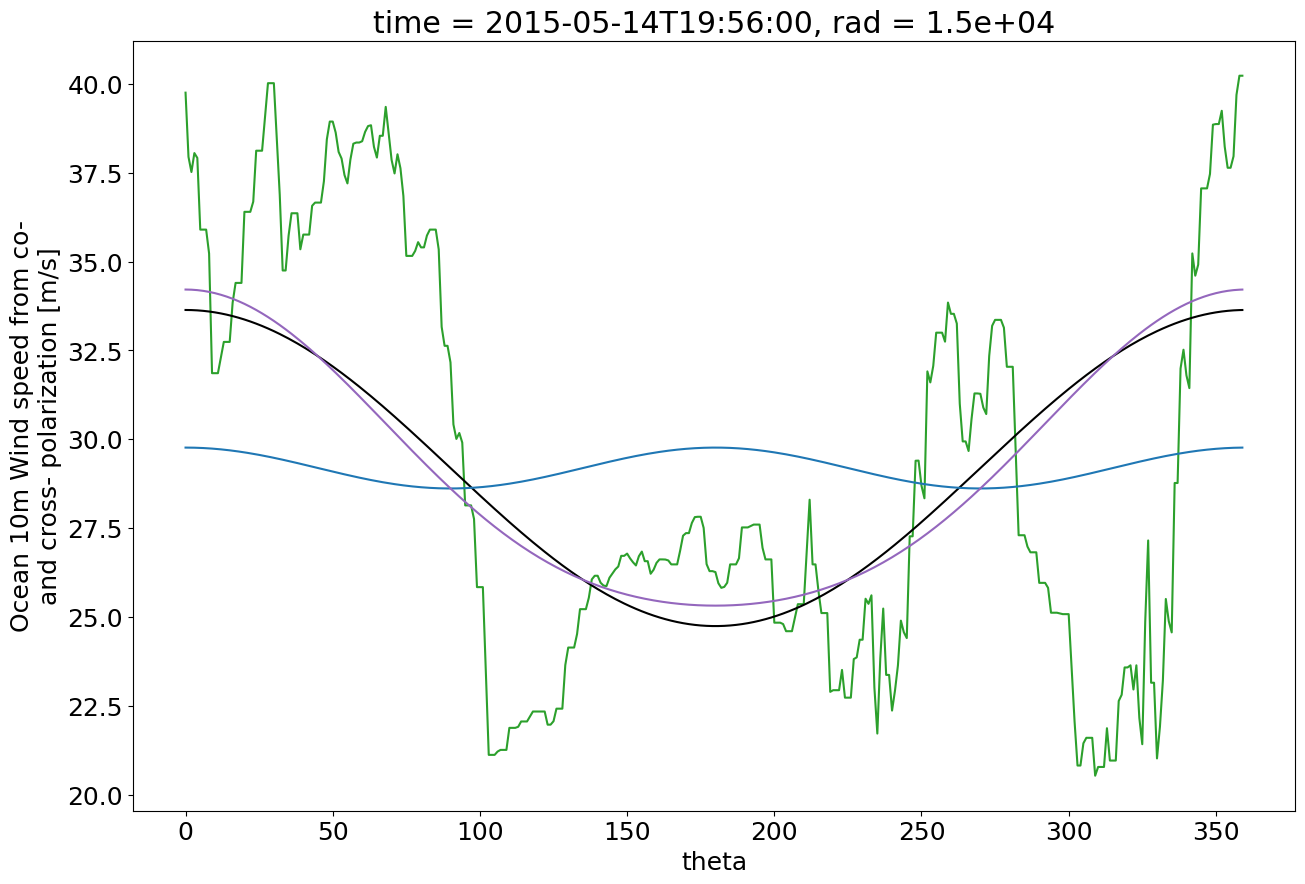

In [10]:
### INVESTIGATE
rad = 15000
valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
if len(valid_dsp.theta) > 10:
    # Amplitude of cosine - WN1
    acn1, phi1, c1                 = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
    # Amplitude of cosine - WN2
    acn2, phi2, c2                 = get_wn2(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
    # Amplitude of cosine - combined WN1&2
    acn1_, phi1_, acn2_, phi2_, c_ = get_wn1and2(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
else:
    acn1  = phi1  = c1    = np.nan
    acn2  = phi2  = c2    = np.nan
    acn1_ = phi1_ = acn2_ = phi2_ = c_ = np.nan

valid_dsp.wind_speed.plot(c='tab:green')
plt.plot(np.array(valid_dsp.theta), wn1(np.deg2rad(valid_dsp.theta), acn1, phi1, c1),    c='k')
plt.plot(np.array(valid_dsp.theta), wn2(np.deg2rad(valid_dsp.theta), acn2, phi2, c2), c='tab:blue')
plt.plot(np.array(valid_dsp.theta), wn1and2(np.deg2rad(valid_dsp.theta), acn1_, phi1_, acn2_, phi2_, c_), c='tab:purple')
# plt.plot(np.array(valid_dsp.theta), wn1(np.deg2rad(valid_dsp.theta), acn, phi, c) + wn2(np.deg2rad(valid_dsp.theta), acn2, phi2, c2), c='tab:gray')

### As a function of r* = r / Rmax

In [14]:
# Reference grid
r_star = np.linspace(0, 16, 321)
# print(r_star)

In [15]:
L_ACN1_STAR     = []
L_ACN2_STAR     = []
L_ACN_HOL1_STAR = []
L_ACN_HOL2_STAR = []
L_ERR1_STAR     = []
L_ERR2_STAR     = []
L_VTS_STAR      = []

for t in tqdm(range(len(dsa.time))):
    dsat          = dsa.isel(time=t)
    acn1_star     = np.interp(r_star, xs / float(dsat.rmx), dsat.acn1)
    acn2_star     = np.interp(r_star, xs / float(dsat.rmx), dsat.acn2)
    acn_hol1_star = np.interp(r_star, xs / float(dsat.rmx), dsat.acn_hol1)
    acn_hol2_star = np.interp(r_star, xs / float(dsat.rmx), dsat.acn_hol2)
    err1_star     = np.interp(r_star, xs / float(dsat.rmx), dsat.err1)
    err2_star     = np.interp(r_star, xs / float(dsat.rmx), dsat.err2)
    vts_star      = np.interp(r_star, xs / float(dsat.rmx), dsat.vts)
    L_ACN1_STAR.append(acn1_star)
    L_ACN2_STAR.append(acn2_star)
    L_ACN_HOL1_STAR.append(acn_hol1_star)
    L_ACN_HOL2_STAR.append(acn_hol2_star)
    L_ERR1_STAR.append(err1_star)
    L_ERR2_STAR.append(err2_star)
    L_VTS_STAR.append(vts_star)

  0%|          | 0/343 [00:00<?, ?it/s]

In [16]:
dsa_star = xr.Dataset(
    data_vars={
        'acn1':      (('time', 'rad'), L_ACN1_STAR),
        'acn2':      (('time', 'rad'), L_ACN2_STAR),
        'acn_hol1':  (('time', 'rad'), L_ACN_HOL1_STAR),
        'acn_hol2':  (('time', 'rad'), L_ACN_HOL2_STAR),
        'err1':      (('time', 'rad'), L_ERR1_STAR),
        'err2':      (('time', 'rad'), L_ERR2_STAR),
        'vts':       (('time', 'rad'), L_VTS_STAR),
        # 'file_tcva': ('time', L_FIL),
    },
    coords={
        'time': dsa.time
    }
)
dsa_star['file_tcva'] = dsa['file_tcva']
dsa_star[list(dsa.keys())[9:-1]] = dsa[list(dsa.keys())[9:-1]]

In [17]:
# Update Southern hemisphere storms
dsa_star['storm_dir_adjusted']                    = dsa_star['storm_dir'].copy(deep=True)
dsa_star['storm_dir_adjusted'][dsa.lat < 0]      += 180

In [18]:
# FILTERS
# keep = (
#     (dsa_star.vts == 360) & 
#     (dsa_star.acn_hol2 < dsa_star.acn_hol1 / 2)
# )

keep = (
    (dsa.lat > 0)
)

dsa_star['keep'] = keep

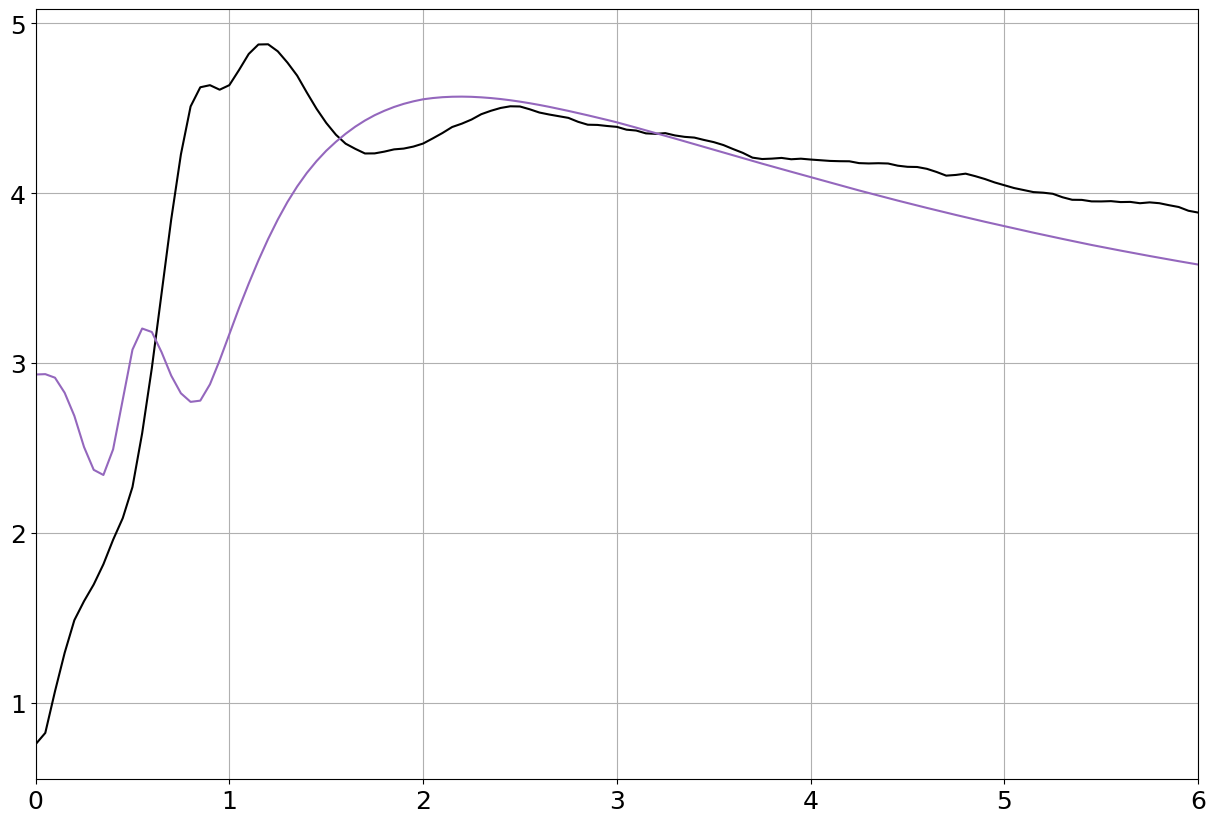

In [19]:
plt.plot(r_star, dsa_star.acn1.where(dsa_star.keep).mean(dim='time'),     c='k')
plt.plot(r_star, dsa_star.acn_hol1.where(dsa_star.keep).mean(dim='time'), c='tab:purple')
plt.xlim(0, 6)
plt.grid()

5.153275688347
4.619722005548604
4.698700148260629
4.667845977468311


Text(0, 0.5, 'Amplitude of asymmetry (m/s)')

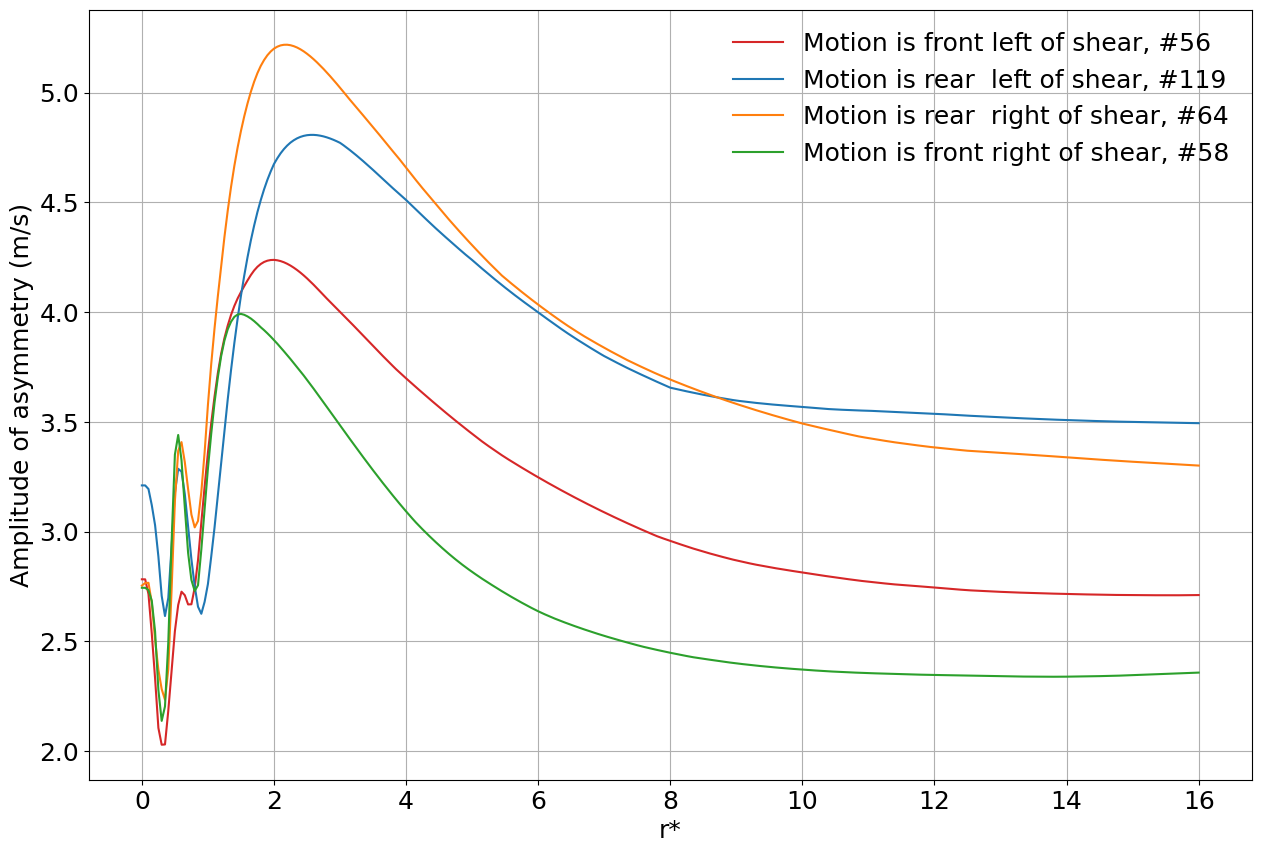

In [28]:
dsa1 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 0)   & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 90),  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 90)  & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 180), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa3 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 180) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 270), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa4 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 270) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 360), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')

# print(float(dsa1.rmx.mean()))
# print(float(dsa2.rmx.mean()))
# print(float(dsa3.rmx.mean()))
# print(float(dsa4.rmx.mean()))

print(float(dsa1.storm_speed.mean()))
print(float(dsa2.storm_speed.mean()))
print(float(dsa3.storm_speed.mean()))
print(float(dsa4.storm_speed.mean()))

plt.plot(r_star, dsa1.acn_hol1.where(dsa1.keep).mean(dim='time'), label='Motion is front left of shear, #{}'.format(len(dsa1.time)),  c='tab:red')
plt.plot(r_star, dsa2.acn_hol1.where(dsa2.keep).mean(dim='time'), label='Motion is rear  left of shear, #{}'.format(len(dsa2.time)),  c='tab:blue')
plt.plot(r_star, dsa3.acn_hol1.where(dsa3.keep).mean(dim='time'), label='Motion is rear  right of shear, #{}'.format(len(dsa3.time)), c='tab:orange')
plt.plot(r_star, dsa4.acn_hol1.where(dsa4.keep).mean(dim='time'), label='Motion is front right of shear, #{}'.format(len(dsa4.time)), c='tab:green')
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('Amplitude of asymmetry (m/s)')

In [31]:
# print(float(dsa1.vmx.mean()))
# print(float(dsa2.vmx.mean()))
# print(float(dsa3.vmx.mean()))
# print(float(dsa4.vmx.mean()))

### As a function of r

In [9]:
# FILTERS
keep = (
    (dsa.vts == 360) & 
    (dsa.acn_hol2 < dsa.acn_hol1 / 2)
)

dsa['keep'] = keep

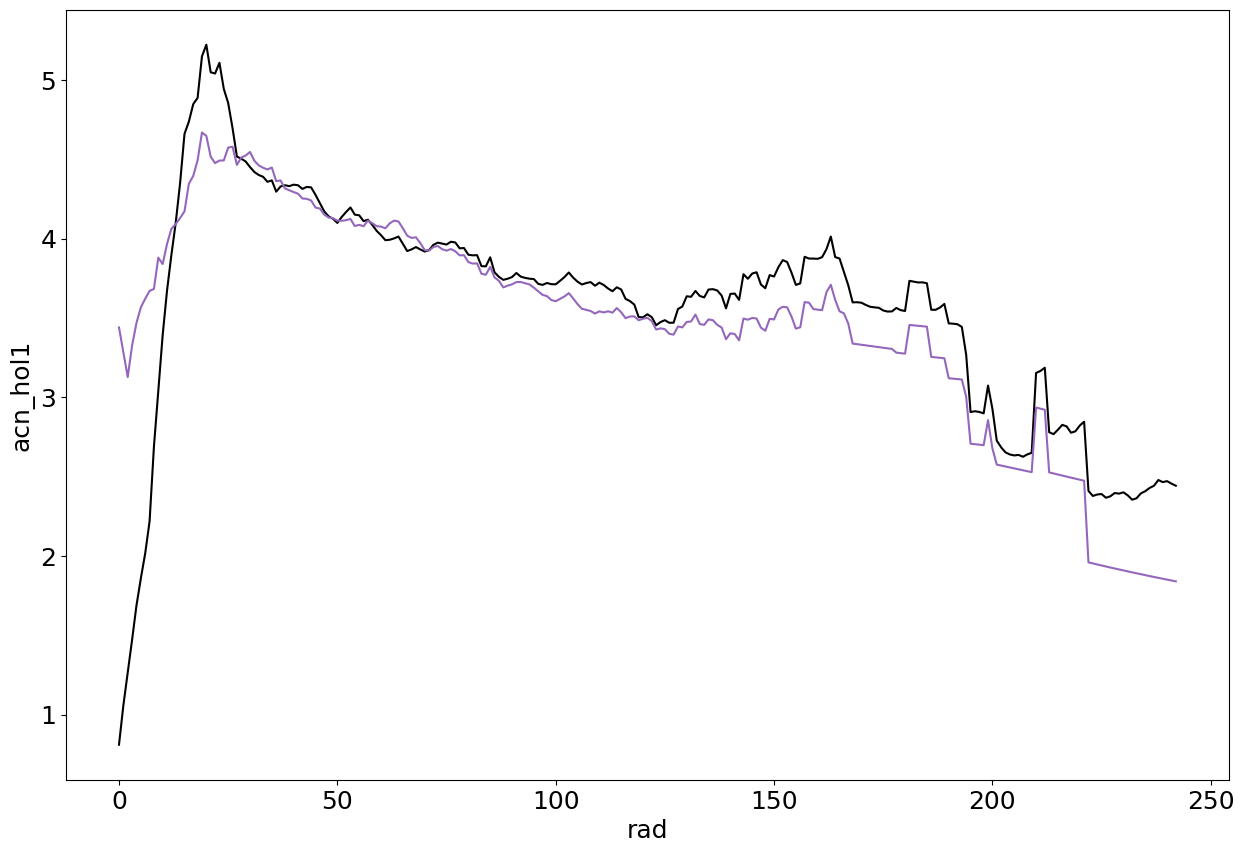

In [10]:
dsa.acn1.where(dsa.keep).mean(dim='time').plot(c='k')
dsa.acn_hol1.where(dsa.keep).mean(dim='time').plot(c='tab:purple')

In [11]:
VWS = [] # Wind shear
MOT = [] # Storm motion
RMX = [] # Rmax
SMD = [] # Storm motion direction
VWD = [] # Vertical wind shear direction
LAT = [] # Latitude, to filter Southern Hemisphere

for t in tqdm(range(len(dsa.time))):
    d_crt = d.where(d.file_tcva == dsa.isel(time=t).file_tcva, drop=True).isel(time=0)
    VWS.append(float(d_crt.vws_pmd))
    MOT.append(float(d_crt.speed))
    RMX.append(float(d_crt.rmx))
    SMD.append(float(d_crt.storm_dir_ibt))
    VWD.append(float(d_crt.wsd_pmd))
    LAT.append(float(d_crt.lat))

  0%|          | 0/343 [00:00<?, ?it/s]

In [12]:
dsa['wind_shear']     = xr.DataArray(data=VWS, dims='time')
dsa['storm_speed']    = xr.DataArray(data=MOT, dims='time')
dsa['rmx']            = xr.DataArray(data=RMX, dims='time')
dsa['storm_dir']      = xr.DataArray(data=SMD, dims='time')
dsa['wind_shear_dir'] = xr.DataArray(data=VWD, dims='time')
dsa['lat']            = xr.DataArray(data=LAT, dims='time')

In [13]:
# Update Southern hemisphere storms
dsa['storm_dir_adjusted']                    = dsa['storm_dir'].copy(deep=True)
dsa['storm_dir_adjusted'][dsa.lat < 0]      += 180

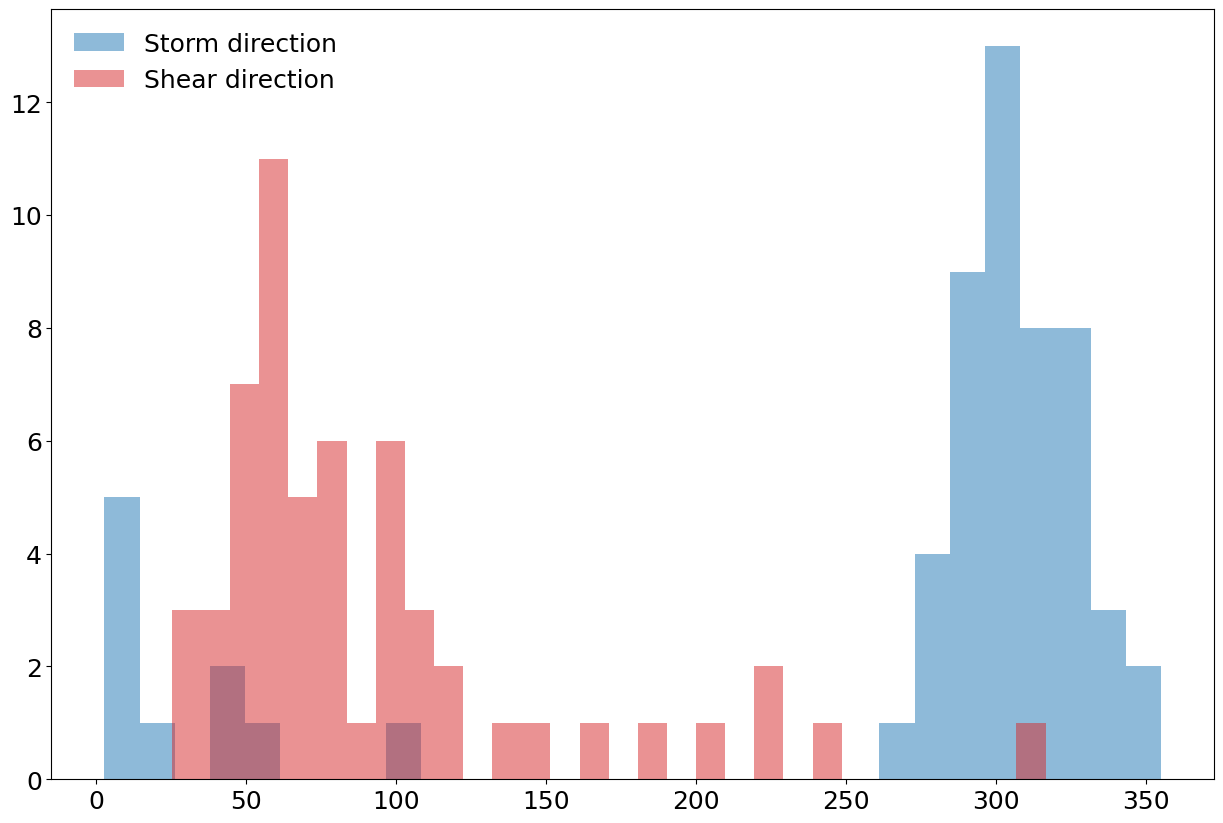

In [18]:
# Fig. 5 of Corbosiero and Molinari
# In North Atlantic, average shear vector from the west-southwest and average motion vector from the south-southwest (1888)

# In my case, the TCs go preferentially toward the Northwest: selection bias toward well-formed systems, far from coast, etc...?
# The wind shear preferentially comes from the West-southwest
# This is still consistent, with an average motion vector ~90-100° left from the wind shear vector

keep_bsn = d.basin == 'al'

plt.hist(d.where(keep_bsn).storm_dir_ibt, label='Storm direction', bins=30, alpha=0.5, color='tab:blue')
plt.hist(d.where(keep_bsn).wsd_pmd,       label='Shear direction', bins=30, alpha=0.5, color='tab:red')
plt.legend(frameon=False)

26750.0
25638.655462184874
26562.5
22827.58620689655


(-4.0, 1.0)

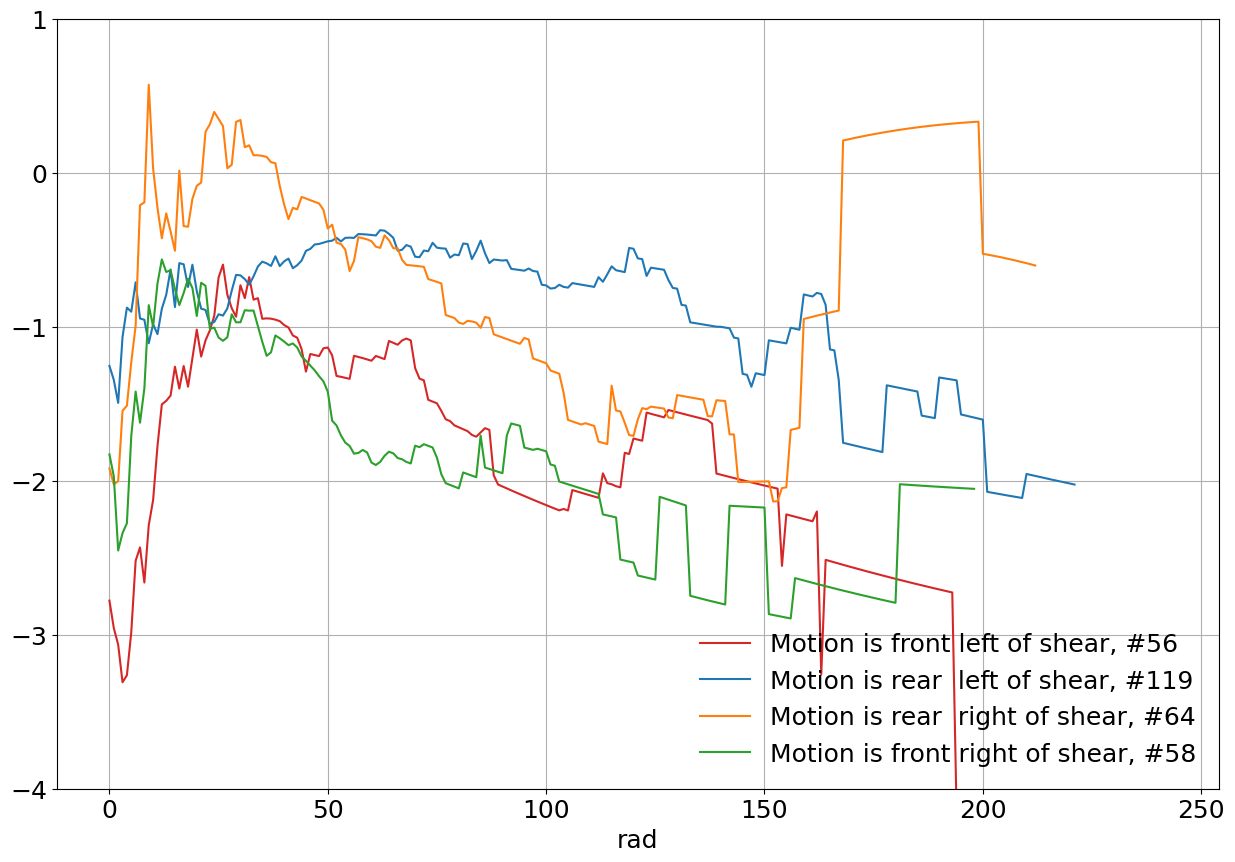

In [22]:
dsa1 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 0)   & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 90),  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 90)  & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 180), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa3 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 180) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 270), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa4 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 270) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 360), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')


print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))
print(float(dsa3.rmx.mean()))
print(float(dsa4.rmx.mean()))

(dsa1.acn_hol1.where(dsa1.keep) - dsa1.storm_speed).mean(dim='time').plot(label='Motion is front left of shear, #{}'.format(len(dsa1.time)),  c='tab:red')
(dsa2.acn_hol1.where(dsa2.keep) - dsa2.storm_speed).mean(dim='time').plot(label='Motion is rear  left of shear, #{}'.format(len(dsa2.time)),  c='tab:blue')
(dsa3.acn_hol1.where(dsa3.keep) - dsa3.storm_speed).mean(dim='time').plot(label='Motion is rear  right of shear, #{}'.format(len(dsa3.time)), c='tab:orange')
(dsa4.acn_hol1.where(dsa4.keep) - dsa4.storm_speed).mean(dim='time').plot(label='Motion is front right of shear, #{}'.format(len(dsa4.time)), c='tab:green')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 1)